In [52]:
pip install cobra

In [53]:
!pip install gurobipy
import gurobipy as gp

### Import packages

In [54]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import cobra

print('Python version:', sys.version)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', matplotlib. __version__)
print('Pickle version:', pickle.format_version)
print('Cobrapy version:', cobra.__version__)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.4
Pandas version: 1.3.0
Matplotlib version: 3.3.3
Pickle version: 4.0
Cobrapy version: 0.20.0


In [55]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Create genome-scale model

In [56]:
from cobra.io import load_json_model, save_json_model, read_sbml_model, write_sbml_model
from cobra import Model, Reaction, Metabolite
from pandas import Series, DataFrame

model = load_json_model('iJN678.json')

In [57]:
#TCA cycle shunt reactions (Zhang and Bryant, 2011)

r_OXGDC = Reaction('OXGDC')
r_OXGDC.name = '2-oxoglutarate decarboxylase'
r_OXGDC.subsystem = 'Citrate cycle (TCA cycle)'
r_OXGDC.gene_reaction_rule = 'sll1981'
r_OXGDC.lower_bound = 0
r_OXGDC.upper_bound = 1000

r_OXGDC.add_metabolites({
                            model.metabolites.get_by_id("akg_c"): -1,
                            model.metabolites.get_by_id("h_c"): -1,
                            model.metabolites.get_by_id("co2_c"): 1,
                            model.metabolites.get_by_id("sucsal_c"): 1,
                           })

model.add_reactions([r_OXGDC])

#Light-independent serine biosynthesis pathway (Klemke et al., 2015)

r_PSTA = Reaction('PSTA')
r_PSTA.name = 'Phosphoserine transaminase'
r_PSTA.subsystem = 'Glycine and serine metabolism'
r_PSTA.gene_reaction_rule = 'sll1559'
r_PSTA.lower_bound = 0
r_PSTA.upper_bound = 1000

m_pser__L_c = Metabolite(id='pser__L_c', name='O-Phospho-L-serine', compartment='c', formula='C3H6NO6P')

r_PSTA.add_metabolites({model.metabolites.get_by_id("3php_c"): -1,
                        model.metabolites.get_by_id("glu__L_c"): -1,
                        model.metabolites.get_by_id("akg_c"): 1,
                        m_pser__L_c: 1, #
                        })

model.add_reactions([r_PSTA])

r_PSP = Reaction('PSP')
r_PSP.name = 'Phosphoserine phosphatase'
r_PSP.subsystem = 'Glycine and serine metabolism'
r_PSP.gene_reaction_rule = 'slr1124'
r_PSP.lower_bound = 0
r_PSP.upper_bound = 1000

r_PSP.add_metabolites({
                            model.metabolites.get_by_id("pser__L_c"): -1,
                            model.metabolites.get_by_id("h2o_c"): -1,
                            model.metabolites.get_by_id("h_c"): 2,
                            model.metabolites.get_by_id("pi_c"): 1,
                            model.metabolites.get_by_id("ser__L_c"): 1,
                            })

model.add_reactions([r_PSP])

#Phosphoketolase pathways (Xiong et al., 2015), (Bachhar et al., 2020)

r_PKETF = Reaction('PKETF')
r_PKETF.name = 'Phosphoketolase (fructose-6-phosphate utilizing)'
r_PKETF.subsystem = 'Pentose phosphate pathway'
r_PKETF.gene_reaction_rule = 'slr0453'
r_PKETF.lower_bound = 0
r_PKETF.upper_bound = 1000

r_PKETF.add_metabolites({model.metabolites.get_by_id("f6p_c"): -1,
                       model.metabolites.get_by_id("pi_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       model.metabolites.get_by_id("actp_c"): 1,
                       model.metabolites.get_by_id("e4p_c"): 1,
                       })

model.add_reactions([r_PKETF])

r_PKETX = Reaction('PKETX')
r_PKETX.name = 'Phosphoketolase (xylulose-5-phosphate utilizing)'
r_PKETX.subsystem = 'Pentose phosphate pathway'
r_PKETX.gene_reaction_rule = 'slr0453'
r_PKETX.lower_bound = 0
r_PKETX.upper_bound = 1000

r_PKETX.add_metabolites({model.metabolites.get_by_id("xu5p__D_c"): -1,
                       model.metabolites.get_by_id("pi_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       model.metabolites.get_by_id("actp_c"): 1,
                       model.metabolites.get_by_id("g3p_c"): 1,
                       })

model.add_reactions([r_PKETX])

#Entner–Doudoroff pathway (Chen et al., 2016)

r_GDH = Reaction('GDH')
r_GDH.name = 'Glucose dehydrogenase'
r_GDH.subsystem = 'Pentose phosphate pathway'
r_GDH.gene_reaction_rule = 'sll1709'
r_GDH.lower_bound = 0
r_GDH.upper_bound = 1000

m_glcn_c = Metabolite(id='glcn_c', name='D-Gluconate', compartment='c', formula='C6H11O7') #, charge='-1'

r_GDH.add_metabolites({model.metabolites.get_by_id("glc__bD_c"): -1,
                       model.metabolites.get_by_id("nadp_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): -1,
                       model.metabolites.get_by_id("nadph_c"): 1,
                       model.metabolites.get_by_id("h_c"): 2,
                       m_glcn_c: 1, #
                       })

model.add_reactions([r_GDH])

r_GNK = Reaction('GNK')
r_GNK.name = 'Gluconokinase'
r_GNK.subsystem = 'Pentose phosphate pathway'
r_GNK.gene_reaction_rule = 'sll0593'
r_GNK.lower_bound = 0
r_GNK.upper_bound = 1000

r_GNK.add_metabolites({model.metabolites.get_by_id("atp_c"): -1,
                       model.metabolites.get_by_id("glcn_c"): -1,
                       model.metabolites.get_by_id("6pgc_c"): 1,
                       model.metabolites.get_by_id("adp_c"): 1,
                       model.metabolites.get_by_id("h_c"): 1,
                       })

model.add_reactions([r_GNK])

r_EDD = Reaction('EDD')
r_EDD.name = '6-phosphogluconate dehydratase'
r_EDD.subsystem = 'Pentose phosphate pathway'
r_EDD.gene_reaction_rule = 'slr0452'
r_EDD.lower_bound = 0
r_EDD.upper_bound = 1000

m_2ddg6p_c = Metabolite(id='2ddg6p_c', name='2-Dehydro-3-deoxy-D-gluconate 6-phosphate', compartment='c', formula='C6H8O9P') #, charge='-3'

r_EDD.add_metabolites({model.metabolites.get_by_id("6pgc_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       m_2ddg6p_c: 1,
                       })

model.add_reactions([r_EDD])

r_EDA = Reaction('EDA')
r_EDA.name = '2-dehydro-3-deoxy-phosphogluconate aldolase'
r_EDA.subsystem = 'Pentose phosphate pathway'
r_EDA.gene_reaction_rule = 'sll0107'
r_EDA.lower_bound = 0
r_EDA.upper_bound = 1000

r_EDA.add_metabolites({model.metabolites.get_by_id("2ddg6p_c"): -1,
                       model.metabolites.get_by_id("g3p_c"): 1,
                       model.metabolites.get_by_id("pyr_c"): 1,
                        })

model.add_reactions([r_EDA])

#Modification to tyrosine biosynthesis (Bonner et al., 2004)

r_PAT1 = Reaction('PAT1')
r_PAT1.name = 'Prephenate transaminase (aspartate donor)'
r_PAT1.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PAT1.gene_reaction_rule = ''
r_PAT1.lower_bound = 0
r_PAT1.upper_bound = 1000

m_Largn_c = Metabolite(id='Largn_c', name='L-Arogenate', compartment='c', formula='C10H13NO5')

r_PAT1.add_metabolites({model.metabolites.get_by_id("pphn_c"): -1,
                       model.metabolites.get_by_id("asp__L_c"): -1,
                       model.metabolites.get_by_id("h_c"): -1,
                       model.metabolites.get_by_id("oaa_c"): 1,
                       m_Largn_c: 1,
                        })

model.add_reactions([r_PAT1])

r_PAT2 = Reaction('PAT2')
r_PAT2.name = 'Prephenate transaminase (glutamate donor)'
r_PAT2.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PAT2.gene_reaction_rule = ''
r_PAT2.lower_bound = 0
r_PAT2.upper_bound = 1000

r_PAT2.add_metabolites({model.metabolites.get_by_id("pphn_c"): -1,
                       model.metabolites.get_by_id("glu__L_c"): -1,
                       model.metabolites.get_by_id("h_c"): -1,
                       model.metabolites.get_by_id("Largn_c"): 1,
                       model.metabolites.get_by_id("akg_c"): 1,
                        })

model.add_reactions([r_PAT2])

r_PHEA = Reaction('PHEA')
r_PHEA.name = 'Prephenate dehydratase'
r_PHEA.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PHEA.gene_reaction_rule = 'sll1662'
r_PHEA.lower_bound = 0
r_PHEA.upper_bound = 1000

r_PHEA.add_metabolites({model.metabolites.get_by_id("Largn_c"): -1,
                       model.metabolites.get_by_id("phe__L_c"): 1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       model.metabolites.get_by_id("co2_c"): 1,
                        })

model.add_reactions([r_PHEA])

r_PHEA = Reaction('TYRA')
r_PHEA.name = 'Arogenate dehydrogenase'
r_PHEA.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PHEA.gene_reaction_rule = 'slr2081'
r_PHEA.lower_bound = 0
r_PHEA.upper_bound = 1000

r_PHEA.add_metabolites({model.metabolites.get_by_id("Largn_c"): -1,
                       model.metabolites.get_by_id("nadp_c"): -1,
                       model.metabolites.get_by_id("tyr__L_c"): 1,
                       model.metabolites.get_by_id("h_c"): 1,
                       model.metabolites.get_by_id("nadph_c"): 1,
                       model.metabolites.get_by_id("co2_c"): 1,
                        })

model.add_reactions([r_PHEA])

#Modification to Glycine Cleavage System (Joshi et al., 2017)

model.reactions.GLYCL_2.bounds = (0, 0)
model.reactions.GLYCL.bounds = (0, 0)

r_GLYCLa = Reaction('GLYCLa')
r_GLYCLa.name = 'Glycine Cleavage System'
r_GLYCLa.subsystem = 'Photorespiration'
r_GLYCLa.gene_reaction_rule = '(sll0171 or slr0879 or slr0293)'
r_GLYCLa.lower_bound = -1000
r_GLYCLa.upper_bound = 1000

m_samprot_c = Metabolite(id='samprot_c', name='S-Aminomethyldihydrolipoylprotein', compartment='c', formula='C6H9N3O')
m_lprot_c = Metabolite(id='lprot_c', name='Lipoylprotein', compartment='c', formula='C6H9N3O')

r_GLYCLa.add_metabolites({model.metabolites.get_by_id("gly_c"): -1,
                       m_lprot_c: -1,
                       model.metabolites.get_by_id("co2_c"): 1,
                       m_samprot_c: 1,
                        })

model.add_reactions([r_GLYCLa])

r_GLYCLb = Reaction('GLYCLb')
r_GLYCLb.name = 'Glycine Cleavage System'
r_GLYCLb.subsystem = 'Photorespiration'
r_GLYCLb.gene_reaction_rule = '(sll0171 or slr0879 or slr0293)'
r_GLYCLb.lower_bound = -1000
r_GLYCLb.upper_bound = 1000

m_dhlprot_c = Metabolite(id='dhlprot_c', name='dihydrolipolprotein', compartment='c', formula='C6H9N3O')

r_GLYCLb.add_metabolites({model.metabolites.get_by_id("thf_c"): -1,
                       model.metabolites.get_by_id("samprot_c"): -1,
                       model.metabolites.get_by_id("mlthf_c"): 1,
                       model.metabolites.get_by_id("nh4_c"): 1,
                       m_dhlprot_c: 1,
                       })

model.add_reactions([r_GLYCLb])

r_GLYCLc = Reaction('GLYCLc')
r_GLYCLc.name = 'Glycine Cleavage System'
r_GLYCLc.subsystem = 'Photorespiration'
r_GLYCLc.gene_reaction_rule = '(sll0171 or slr0879 or slr0293)'
r_GLYCLc.lower_bound = -1000
r_GLYCLc.upper_bound = 1000

m_dhlprot_c = Metabolite(id='dhlprot_c', name='dihydrolipolprotein', compartment='c', formula='C6H9N3O')

r_GLYCLc.add_metabolites({model.metabolites.get_by_id("nad_c"): -1,
                       model.metabolites.get_by_id("dhlprot_c"): -1,
                       model.metabolites.get_by_id("h_c"): 1,
                       model.metabolites.get_by_id("nadh_c"): 1,
                       model.metabolites.get_by_id("lprot_c"): 1,
                        })

model.add_reactions([r_GLYCLc])

#Modification to electron-transport chain reactions (Lea-Smith et al., 2015).

model.reactions.NDH1_1p.bounds = (0, 0)
model.reactions.NDH1_2p.bounds = (0, 0)
model.reactions.CBFCpp.bounds = (0, 0)
model.reactions.CBFC2pp.bounds = (0, 0)
model.reactions.CYO1b2pp_syn.bounds = (0, 0)
model.reactions.CYO1bpp_syn.bounds = (0, 0)
model.reactions.CYO1b2_syn.bounds = (0, 0)

r_NDH2_2p = Reaction('NDH2_1p')
r_NDH2_2p.name = 'NADH dehydrogenase 2'
r_NDH2_2p.subsystem = 'Oxidative phosphorylation'
r_NDH2_2p.gene_reaction_rule = 'slr1743'
r_NDH2_2p.lower_bound = 0
r_NDH2_2p.upper_bound = 1000

r_NDH2_2p.add_metabolites({model.metabolites.get_by_id("h_c"): -1,
                       model.metabolites.get_by_id("nadh_c"): -1,
                       model.metabolites.get_by_id("pq_p"): -1,
                       model.metabolites.get_by_id("nad_c"): 1,
                       model.metabolites.get_by_id("pqh2_p"): 1,
                       })

model.add_reactions([r_NDH2_2p])

r_ARTO = Reaction('ARTO')
r_ARTO.name = 'Alternative respiratory terminal oxidase'
r_ARTO.subsystem = 'Photosynthesis'
r_ARTO.gene_reaction_rule = '(slr2082 or slr2083 or sll0813)'
r_ARTO.lower_bound = 0
r_ARTO.upper_bound = 1000

r_ARTO.add_metabolites({model.metabolites.get_by_id("h_c"): -2,
                       model.metabolites.get_by_id("pqh2_p"): -1,
                       model.metabolites.get_by_id("o2_p"): -0.5,
                       model.metabolites.get_by_id("pq_p"): 1,
                       model.metabolites.get_by_id("h2o_p"): 1,
                       })

model.add_reactions([r_ARTO])

r_Flv2_Flv4 = Reaction('Flv2_4')
r_Flv2_Flv4.name = 'Flavodiiron 2/4'
r_Flv2_Flv4.subsystem = 'Photosynthesis'
r_Flv2_Flv4.gene_reaction_rule = '(sll0219 or sll0217)'
r_Flv2_Flv4.lower_bound = 0
r_Flv2_Flv4.upper_bound = 1000

r_Flv2_Flv4.add_metabolites({model.metabolites.get_by_id("h_c"): -2,
                                    model.metabolites.get_by_id("pqh2_u"): -1,
                                    model.metabolites.get_by_id("o2_u"): -0.5,
                                    model.metabolites.get_by_id("pq_u"): 1,
                                    model.metabolites.get_by_id("h2o_u"): 1,
                                    })

model.add_reactions([r_Flv2_Flv4])

#Modification to transhydrogenase PntAB (Kämäräinen, et al., 2016).

#model.reactions.NADTRHD.bounds = (-1000, 10000)

#Modification to Leucine transaminas (Joshi et al., 2017).
model.reactions.LEUTAi.bounds = (0, 0)

#ATP maintenance requirement

r_NGAM = Reaction('ATPM')
r_NGAM.name = 'ATP maintenance requirement'
r_NGAM.subsystem = 'Biomass and maintenance functions'
r_NGAM.gene_reaction_rule = ''
r_NGAM.lower_bound = 0
r_NGAM.upper_bound = 1000

r_NGAM.add_metabolites({model.metabolites.get_by_id("atp_c"): -1,
                                    model.metabolites.get_by_id("h2o_c"): -1,
                                    model.metabolites.get_by_id("adp_c"): 1,
                                    model.metabolites.get_by_id("h_c"): 1,
                                    model.metabolites.get_by_id("pi_c"): 1,
                        })

model.add_reactions([r_NGAM])

In [59]:
# Biosynthesis reactions

r_und1 = Reaction('tesA')
r_und1.name = 'Acyl-ACP thioesterase'
r_und1.subsystem = 'Fatty acid biosynthesis'
r_und1.gene_reaction_rule = 'EcTesA'
r_und1.lower_bound = 0
r_und1.upper_bound = 1000

m_dodecacid_c = Metabolite(id='dodecacid_c', name='Dodecanoate (n-C12:0)', compartment='c', formula='C12H23O2')
r_und1.add_metabolites({
                            model.metabolites.get_by_id("ddcaACP_c"): -1,
                            model.metabolites.get_by_id("h2o_c"): -1,
                            model.metabolites.get_by_id("ACP_c"): 1,
                            model.metabolites.get_by_id("h_c"): 1,
                            m_dodecacid_c: 1,                       
                            })

model.add_reactions([r_und1])

r_und2 = Reaction('UndB')
r_und2.name = 'Desaturase-like'
r_und2.subsystem = 'Fatty acid biosynthesis'
r_und2.gene_reaction_rule = 'PmUndB'
r_und2.lower_bound = 0
r_und2.upper_bound = 1000

m_undecene_c = Metabolite(id='und_c', name='1-undecene', compartment='c', formula='C11H22')
r_und2.add_metabolites({
                            model.metabolites.get_by_id("dodecacid_c"): -1,
                            #model.metabolites.get_by_id("o2_c"): -1,
                            model.metabolites.get_by_id("co2_c"): 1,
                            model.metabolites.get_by_id("h_c"): 1,
                            m_undecene_c: 1,                       
                            })

model.add_reactions([r_und2])

# Transport reactions
r_und3 = Reaction('UNDt')
r_und3.name = '1-undecene transport via diffusion (cytoplasm to extracellular)'
r_und3.subsystem = 'Fatty acid biosynthesis'
r_und3.gene_reaction_rule = ''
r_und3.lower_bound = 0
r_und3.upper_bound = 1000

m_undecene_e = Metabolite(id='und_e', name='1-undecene', compartment='e', formula='C11H22')
r_und3.add_metabolites({
                            model.metabolites.get_by_id("und_c"): -1,
                            m_undecene_e: 1,
                            })

model.add_reactions([r_und3])

# Exchange reactions
r_und4 = Reaction('EX_und_e')
r_und4.name = '1-undecene exchange'
r_und4.subsystem = 'Fatty acid biosynthesis'
r_und4.gene_reaction_rule = ''
r_und4.lower_bound = 0
r_und4.upper_bound = 1000

r_und4.add_metabolites({model.metabolites.get_by_id("und_e") : -1})
model.add_reactions([r_und4])

r_und4

Reaction identifier,EX_und_e
Name,1-undecene exchange
Memory address,0x02ca83d4ad60
Stoichiometry,und_e --> 1-undecene -->
GPR,
Lower bound,0
Upper bound,1000


In [140]:
#save new GSM

#cobra.io.write_sbml_model(model,'iJN678_AK_1_undecene.xml')
#cobra.io.save_json_model(model, "iJN678_AK_1_undecene.json")

### MEMOTE analysis

In [61]:
pip install memote

In [62]:
#import memote
#!memote report snapshot '/iJN678_2023_1_undecene.xml' --filename '/iJN678_2023_1_undecene.html'

### Set model constraints

In [63]:
#set model objective to autotrophic growth
model.objective = 'BIOMASS_Ec_SynAuto'
#set photoautotropic growth by constraining glucose exchange reatcion
model.reactions.EX_glc__D_e.bounds = (0, 1000)
#set photoautotropic growth by constraining HCO3 exchange reatcion.
model.reactions.EX_co2_e.bounds = (0, 1000)
model.reactions.EX_hco3_e.bounds = (-3.7, 1000)
#set photon flux to lab scale conditions.
model.reactions.EX_photon_e.bounds = (-45, -45)
#blocking transhydrogenase PntAB
model.reactions.NADTRHD.bounds = (0, 0)

In [64]:
from cobra.flux_analysis.loopless import add_loopless

add_loopless(model)

### Phenotype phase plane

<AxesSubplot:xlabel='Growth rate (1/h)', ylabel='Production rate (mmol/gDW/h)'>

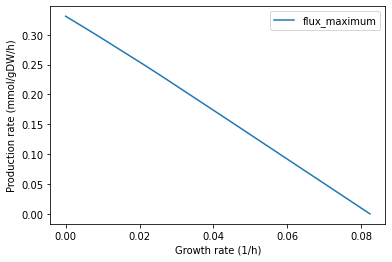

In [65]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope

ppp = production_envelope(model,
                    reactions=[model.reactions.BIOMASS_Ec_SynAuto],
                    objective=model.reactions.EX_und_e)
ppp.plot(x='BIOMASS_Ec_SynAuto', y='flux_maximum', xlabel = 'Growth rate (1/h)', ylabel = 'Production rate (mmol/gDW/h)')

### Set growth and alkene production rate

In [66]:
pfba_solution = cobra.flux_analysis.pfba(model)
uMAX = pfba_solution.fluxes["BIOMASS_Ec_SynAuto"]
uMAX

0.08239896941174903

In [67]:
model.reactions.BIOMASS_Ec_SynAuto.lower_bound = 0.1 * uMAX
model.objective = model.reactions.EX_und_e
pfba_solution = cobra.flux_analysis.pfba(model)
production = abs(pfba_solution.fluxes["EX_und_e"])
production

0.2999745094197124

In [136]:
pip install escher

In [138]:
import escher
from escher import Builder

pfba_solution_escher = cobra.flux_analysis.pfba(model)

builder = Builder(
    map_json = '#AMP_SOG_SER_PSP_map_titles.json',
    model_json='iJN678_2023_undecene_auto.json',
    reaction_data=abs(pfba_solution_escher.fluxes)
)

builder.save_html('AMP_SOG_SER_PSP_iJN678_2023_undecene_auto.html')

### Productivity and yield

In [68]:
with model as model:
    model.objective = model.reactions.EX_und_e
    pfba_solution = cobra.flux_analysis.pfba(model)
    production = abs(pfba_solution.fluxes["EX_und_e"])
    print("Maximum productivity =", production, "[mmol p/gDW/h]")
       
    #Calculate a molar yield (mol product / mol carbon source)
    maximum_theoretical_yield = production / abs(pfba_solution.fluxes["EX_hco3_e"])
    print("Maximum theoretical molar yield =", maximum_theoretical_yield, "[mmol p / mmol s]")
          
    #Calculate a mass yield instead of molar yield (g (product) / g (carbon source))
    mw_p = model.metabolites.get_by_id("und_e").formula_weight
    mw_s = model.metabolites.hco3_c.formula_weight
    g_dw_p_per_g_s = "{:.2f}".format(maximum_theoretical_yield * (mw_p / mw_s))
    print("Maximum theoretical mass yield =", g_dw_p_per_g_s, "[gram p / gram s]")

    #Calculate C-mol yield (C-mol product / C-mol carbon source)
    #print(model.metabolites.get_by_id("und_e").formula)
    #print(model.metabolites.get_by_id("hco3_e").formula)
    cmol_p = mw_p/11
    cmol_s = mw_s/1
    cmol_yield = float(g_dw_p_per_g_s) * float(cmol_s/cmol_p)
    print("C-mol yield =", cmol_yield, "[C-mol p / C-mol s]")

Maximum productivity = 0.2999745094197124 [mmol p/gDW/h]
Maximum theoretical molar yield = 0.0823024086383038 [mmol p / mmol s]
Maximum theoretical mass yield = 0.21 [gram p / gram s]
C-mol yield = 0.9135182204072552 [C-mol p / C-mol s]


In [69]:
data = {'Productivity ': [production], 'Mass yield': [g_dw_p_per_g_s], 'C-mol yield': [cmol_yield]}
productivity = pd.DataFrame(data=data, index=['1-undecene'])
productivity_round = productivity.round(2)
productivity_round

,Productivity,Mass yield,C-mol yield
1-undecene,0.3,0.21,0.91


In [70]:
import pickle

with open('1_undecene_auto_productivity.pickle', 'wb') as handle:
    pickle.dump(productivity_round, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Flux variability analysis

In [71]:
from cobra.flux_analysis.variability import flux_variability_analysis

fva = flux_variability_analysis(model, fraction_of_optimum = 0.95, reaction_list=model.reactions)

for rxn in model.reactions: 
    pfba_all = pfba_solution.fluxes.to_frame()

merge = pfba_all.join(fva)

with pd.ExcelWriter('pfba_fva_1_undecene_auto_all.xlsx') as writer:
    merge.to_excel(writer, sheet_name='auto_1_undecene')

In [72]:
#Pyruvate

df_pyr = model.metabolites.pyr_c.summary(fva=0.95).to_frame()
rxn_name_pyr = []
rxn_subsystem_pyr = []
rxn_string_pyr = []

rxn_pyr = df_pyr['reaction'].tolist()
for i in range(len(rxn_pyr)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_pyr[i]:
            name_pyr = model.reactions[j].name
            rxn_name_pyr.append(name_pyr)
            subsystem_pyr = model.reactions[j].subsystem
            rxn_subsystem_pyr.append(subsystem_pyr)
            string_pyr = model.reactions[j].build_reaction_string()
            rxn_string_pyr.append(string_pyr)
df_pyr.insert(0, 'desciption', rxn_name_pyr)
df_pyr.insert(1, 'subsystem', rxn_subsystem_pyr)
df_pyr.insert(7, 'string', rxn_string_pyr)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_pyr_produce = df_pyr.loc[((df_pyr["flux"] > 0) & ((df_pyr["factor"] > 0) | (df_pyr["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_pyr_consume = df_pyr.loc[((df_pyr["flux"] < 0) & ((df_pyr["factor"] < 0) | (df_pyr["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_pyr_produce = (df_pyr_produce['flux'] / 
                  df_pyr_produce['flux'].sum()) * 100
df_pyr_produce.insert(3, 'percent', percent_pyr_produce)

percent_pyr_consume = (df_pyr_consume['flux'] / 
                  df_pyr_consume['flux'].sum()) * 100
df_pyr_consume.insert(3, 'percent', percent_pyr_consume)

In [73]:
df_pyr_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ME2,Malic enzyme (NADP),Pyruvate metabolism,0.006985,30.020821,0.000000,1.034930,mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c
PYK,Pyruvate kinase,Glycolysis/Gluconeogenesis,0.006393,27.476232,0.000000,2.068105,adp_c + h_c + pep_c --> atp_c + pyr_c
PYK2,Pyruvate kinase(2),Glycolysis/Gluconeogenesis,0.004689,20.151493,0.000000,2.067518,h_c + pep_c + udp_c --> pyr_c + utp_c
PYK3,Pyruvate kinase(3),Glycolysis/Gluconeogenesis,0.003179,13.664100,0.000000,2.067106,gdp_c + h_c + pep_c --> gtp_c + pyr_c
PYK4,Pyruvate kinase(4),Glycolysis/Gluconeogenesis,0.001413,6.072574,0.000000,2.067904,cdp_c + h_c + pep_c --> ctp_c + pyr_c
ANS,Anthranilate synthase,Phenylalanine tyrosine and tryptophan biosynth...,0.000587,2.524934,0.000587,0.000874,chor_c + gln__L_c --> anth_c + glu__L_c + h_c ...
SHCHCS2,"2-succinyl-6-hydroxy-2,4-cyclohexadiene 1-carb...",Ubiquinone and other pterpenoids biosynthesis,0.000014,0.058235,0.000014,0.000020,ichor_c + ssaltpp_c --> 2shchc_c + pyr_c + thm...
ADCL,4-aminobenzoate synthase,Folate biosynthesis,0.000007,0.031612,0.000000,0.000011,4adcho_c --> 4abz_c + h_c + pyr_c


In [74]:
df_pyr_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ACLS,Acetolactate synthase,C5-Branched dibasic acid metabolism,-0.013773,59.196850,-0.020493,-0.013764,h_c + 2.0 pyr_c --> alac__S_c + co2_c
ACHBS,2-aceto-2-hydroxybutanoate synthase,Valine leucine and isoleucine biosynthesis,-0.002380,10.230838,-0.003470,-0.002380,2obut_c + h_c + pyr_c --> 2ahbut_c + co2_c
ALAD_L,L-alanine dehydrogenase,"Alanine, aspartate and glutamate metabolism",-0.002051,8.815910,-0.208444,0.000000,ala__L_c + h2o_c + nad_c <-- h_c + nadh_c + nh...
DHDPS,Dihydrodipicolinate synthase,Lysine metabolism,-0.001795,7.714227,-0.002671,-0.001795,aspsa_c + pyr_c --> 23dhdp_c + 2.0 h2o_c + h_c
AGTi,Alanine glyoxylate aminotransferase irreversi...,Glyoxylate and dicarboxylate metabolism,-0.001792,7.702525,-0.005722,0.204466,ala__L_c + glx_c <=> gly_c + pyr_c
DXPS,1-deoxy-D-xylulose 5-phosphate synthase,Sterol biosynthesis,-0.001475,6.339651,-0.002195,-0.001458,g3p_c + h_c + pyr_c --> co2_c + dxyl5p_c


In [75]:
#ATP

df_atp = model.metabolites.atp_c.summary(fva=0.95).to_frame()
rxn_name_atp = []
rxn_subsystem_atp = []
rxn_string_atp = []

rxn_atp = df_atp['reaction'].tolist()
for i in range(len(rxn_atp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_atp[i]:
            name_atp = model.reactions[j].name
            rxn_name_atp.append(name_atp)
            subsystem_atp = model.reactions[j].subsystem
            rxn_subsystem_atp.append(subsystem_atp)
            string_atp = model.reactions[j].build_reaction_string()
            rxn_string_atp.append(string_atp)
df_atp.insert(0, 'desciption', rxn_name_atp)
df_atp.insert(1, 'subsystem', rxn_subsystem_atp)
df_atp.insert(7, 'string', rxn_string_atp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_atp_produce = df_atp.loc[((df_atp["flux"] > 0) & ((df_atp["factor"] > 0) | (df_atp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_atp_consume = df_atp.loc[((df_atp["flux"] < 0) & ((df_atp["factor"] < 0) | (df_atp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_atp_produce = (df_atp_produce['flux'] / 
                  df_atp_produce['flux'].sum()) * 100
df_atp_produce.insert(3, 'percent', percent_atp_produce)

percent_atp_consume = (df_atp_consume['flux'] / 
                  df_atp_consume['flux'].sum()) * 100
df_atp_consume.insert(3, 'percent', percent_atp_consume)

In [76]:
df_atp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ATPSu,ATP synthetase(u),Oxidative phosphorylation,14.463816,99.954305,14.244618,15.563129,3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c ...
PYK,Pyruvate kinase,Glycolysis/Gluconeogenesis,0.006393,0.044179,0.000000,2.068105,adp_c + h_c + pep_c --> atp_c + pyr_c
URIDK2r,Uridylate kinase (dUMP),Pyrimidine metabolism,0.000218,0.001503,0.000218,0.000324,atp_c + dump_c <=> adp_c + dudp_c
PPK2,Polyphosphate kinase,Oxidative phosphorylation,0.000002,0.000013,0.000002,0.000003,atp_c + ppi_c <=> adp_c + pppi_c


In [77]:
df_atp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PGK,Phosphoglycerate kinase,Glycolysis/Gluconeogenesis,-7.835041,54.145188,-9.422516,-7.471014,3pg_c + atp_c <=> 13dpg_c + adp_c
PRUK,Phosphoribulokinase,Carbon fixation,-3.949105,27.290863,-5.629546,-3.768588,atp_c + ru5p__D_c --> adp_c + h_c + rb15bp_c
ACCOAC,Acetyl-CoA carboxylase,Pyruvate metabolism,-1.524019,10.531956,-1.524272,-1.449031,accoa_c + atp_c + hco3_c <=> adp_c + h_c + mal...
BCT1_syn,Bicarbonate transport via ABC system (periplasm),Transport,-0.538277,3.719839,-2.739675,0.000000,atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_...
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,-0.440721,3.045665,-0.647485,-0.440721,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...
...,...,...,...,...,...,...,...
GTHS,Glutathione synthetase,Glutamate metabolism,-0.000002,0.000013,-0.000003,0.000000,atp_c + glucys_c + gly_c --> adp_c + gthrd_c +...
LTHRK,L threonine kinase,Porphyrin and chlorophyll metabolism,-0.000002,0.000013,-0.000003,-0.000002,atp_c + thr__L_c --> adp_c + h_c + thrp_c
CYRDAAT,"Cob(I)yrinic acid a,c-diamide adenosyltransferase",Porphyrin and chlorophyll metabolism,-0.000002,0.000013,-0.000003,-0.000002,atp_c + co1dam_c + h_c --> adcobdam_c + pppi_c
COCHL,Cobaltochelatase,Porphyrin and chlorophyll metabolism,-0.000002,0.000013,-0.000002,-0.000002,atp_c + cobalt2_c + h2o_c + hgbam_c --> adp_c ...


In [78]:
#ADP

df_adp = model.metabolites.adp_c.summary(fva=0.95).to_frame()
rxn_name_adp = []
rxn_subsystem_adp = []
rxn_string_adp = []

rxn_adp = df_adp['reaction'].tolist()
for i in range(len(rxn_adp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_adp[i]:
            name_adp = model.reactions[j].name
            rxn_name_adp.append(name_adp)
            subsystem_adp = model.reactions[j].subsystem
            rxn_subsystem_adp.append(subsystem_adp)
            string_adp = model.reactions[j].build_reaction_string()
            rxn_string_adp.append(string_adp)
df_adp.insert(0, 'desciption', rxn_name_adp)
df_adp.insert(1, 'subsystem', rxn_subsystem_adp)
df_adp.insert(7, 'string', rxn_string_adp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_adp_produce = df_adp.loc[((df_adp["flux"] > 0) & ((df_adp["factor"] > 0) | (df_adp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_adp_consume = df_adp.loc[((df_adp["flux"] < 0) & ((df_adp["factor"] < 0) | (df_adp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_adp_produce = (df_adp_produce['flux'] / 
                  df_adp_produce['flux'].sum()) * 100
df_adp_produce.insert(3, 'percent', percent_adp_produce)

percent_adp_consume = (df_adp_consume['flux'] / 
                  df_adp_consume['flux'].sum()) * 100
df_adp_consume.insert(3, 'percent', percent_adp_consume)

In [79]:
df_adp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PGK,Phosphoglycerate kinase,Glycolysis/Gluconeogenesis,7.835041,54.144377,7.471014,9.422516,3pg_c + atp_c <=> 13dpg_c + adp_c
PRUK,Phosphoribulokinase,Carbon fixation,3.949105,27.290454,3.768588,5.629430,atp_c + ru5p__D_c --> adp_c + h_c + rb15bp_c
ACCOAC,Acetyl-CoA carboxylase,Pyruvate metabolism,1.524019,10.531798,1.449031,1.524272,accoa_c + atp_c + hco3_c <=> adp_c + h_c + mal...
BCT1_syn,Bicarbonate transport via ABC system (periplasm),Transport,0.538277,3.719783,0.000000,2.739675,atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_...
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,0.439599,3.037864,0.439599,0.645836,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...
...,...,...,...,...,...,...,...
LTHRK,L threonine kinase,Porphyrin and chlorophyll metabolism,0.000002,0.000013,0.000002,0.000003,atp_c + thr__L_c --> adp_c + h_c + thrp_c
GLUCYS,Gamma-glutamylcysteine synthetase,Glutamate metabolism,0.000002,0.000013,0.000000,0.000002,atp_c + cys__L_c + glu__L_c --> adp_c + glucys...
COCHL,Cobaltochelatase,Porphyrin and chlorophyll metabolism,0.000002,0.000013,0.000002,0.000002,atp_c + cobalt2_c + h2o_c + hgbam_c --> adp_c ...
ADCPS2,Adenosylcobinamide-phosphate synthase,Porphyrin and chlorophyll metabolism,0.000002,0.000013,0.000002,0.000003,adcobhex_c + applp_c + atp_c --> adocbip_c + a...


In [80]:
df_adp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ATPSu,ATP synthetase(u),Oxidative phosphorylation,-14.463816,99.952807,-15.563129,-14.244618,3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c ...
PYK,Pyruvate kinase,Glycolysis/Gluconeogenesis,-0.006393,0.044179,-2.068105,0.000000,adp_c + h_c + pep_c --> atp_c + pyr_c
URIDK2r,Uridylate kinase (dUMP),Pyrimidine metabolism,-0.000218,0.001503,-0.000324,-0.000218,atp_c + dump_c <=> adp_c + dudp_c
RNDR1,Ribonucleoside-diphosphate reductase (ADP),Purine metabolism,-0.000217,0.001498,-0.000322,-0.000217,adp_c + trdrd_c --> dadp_c + h2o_c + trdox_c
PPK2,Polyphosphate kinase,Oxidative phosphorylation,-0.000002,0.000013,-0.000003,-0.000002,atp_c + ppi_c <=> adp_c + pppi_c


In [81]:
#AMP

df_amp = model.metabolites.amp_c.summary(fva=0.95).to_frame()
rxn_name_amp = []
rxn_subsystem_amp = []
rxn_string_amp = []

rxn_amp = df_amp['reaction'].tolist()
for i in range(len(rxn_amp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_amp[i]:
            name_amp = model.reactions[j].name
            rxn_name_amp.append(name_amp)
            subsystem_amp = model.reactions[j].subsystem
            rxn_subsystem_amp.append(subsystem_amp)
            string_amp = model.reactions[j].build_reaction_string()
            rxn_string_amp.append(string_amp)
df_amp.insert(0, 'desciption', rxn_name_amp)
df_amp.insert(1, 'subsystem', rxn_subsystem_amp)
df_amp.insert(7, 'string', rxn_string_amp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_amp_produce = df_amp.loc[((df_amp["flux"] > 0) & ((df_amp["factor"] > 0) | (df_amp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_amp_consume = df_amp.loc[((df_amp["flux"] < 0) & ((df_amp["factor"] < 0) | (df_amp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_amp_produce = (df_amp_produce['flux'] / 
                  df_amp_produce['flux'].sum()) * 100
df_amp_produce.insert(3, 'percent', percent_amp_produce)

percent_amp_consume = (df_amp_consume['flux'] / 
                  df_amp_consume['flux'].sum()) * 100
df_amp_consume.insert(3, 'percent', percent_amp_consume)

In [82]:
df_amp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PRPPS,Phosphoribosylpyrophosphate synthetase,Pentose phosphate pathway,0.006815,39.473797,0.006777,1.029490,atp_c + r5p_c <=> amp_c + h_c + prpp_c
ARGSS,Argininosuccinate synthase,"Alanine, aspartate and glutamate metabolism",0.002241,12.980071,0.002241,0.896442,asp__L_c + atp_c + citr__L_c --> amp_c + argsu...
ADSL1r,Adenylsuccinate lyase,Purine metabolism,0.002074,12.012121,0.002065,0.003086,dcamp_c <=> amp_c + fum_c
ASNS1,Asparagine synthase (glutamine-hydrolysing),Nitrogen metabolism,0.001537,8.904925,0.001537,0.683296,asp__L_c + atp_c + gln__L_c + h2o_c --> amp_c ...
BPNT,"3',5'-bisphosphate nucleotidase",Sulfur Cysteine and methionine metabolism,0.001532,8.874689,0.001526,0.002280,h2o_c + pap_c --> amp_c + pi_c
GLUTRS,Glutamyl-tRNA synthetase,Glutamate metabolism,0.001456,8.431789,0.001441,0.002166,atp_c + glu__L_c + trnaglu_c --> amp_c + glutr...
GMPS,GMP synthase,Glutamate metabolism,0.001302,7.541899,0.000000,0.001937,atp_c + nh4_c + xmp_c --> amp_c + gmp_c + 2.0 ...
ADPT,Adenine phosphoribosyltransferase,Purine metabolism,0.000263,1.523408,0.000248,1.022997,ade_c + prpp_c --> amp_c + ppi_c
NADS2,Nicotinate-mononucleotide adenylyltransferase,Glutamate metabolism,0.000019,0.108724,0.000015,0.000019,atp_c + dnad_c + gln__L_c + h2o_c --> amp_c + ...
SUCBZL,O-succinylbenzoate-CoA ligase,Ubiquinone and other pterpenoids biosynthesis,0.000014,0.078482,0.000014,0.000020,atp_c + coa_c + sucbz_c --> amp_c + ppi_c + sb...


In [83]:
df_amp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ADK1,Adenylate kinase,Purine metabolism,-0.017265,100.0,-2.062222,-0.017241,amp_c + atp_c <=> 2.0 adp_c


In [84]:
#Pi

df_pi = model.metabolites.pi_c.summary(fva=0.95).to_frame()
rxn_name_pi = []
rxn_subsystem_pi = []
rxn_string_pi = []

rxn_pi = df_pi['reaction'].tolist()
for i in range(len(rxn_pi)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_pi[i]:
            name_pi = model.reactions[j].name
            rxn_name_pi.append(name_pi)
            subsystem_pi = model.reactions[j].subsystem
            rxn_subsystem_pi.append(subsystem_pi)
            string_pi = model.reactions[j].build_reaction_string()
            rxn_string_pi.append(string_pi)
df_pi.insert(0, 'desciption', rxn_name_pi)
df_pi.insert(1, 'subsystem', rxn_subsystem_pi)
df_pi.insert(7, 'string', rxn_string_pi)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_pi_produce = df_pi.loc[((df_pi["flux"] > 0) & ((df_pi["factor"] > 0) | (df_pi["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_pi_consume = df_pi.loc[((df_pi["flux"] < 0) & ((df_pi["factor"] < 0) | (df_pi["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_pi_produce = (df_pi_produce['flux'] / 
                  df_pi_produce['flux'].sum()) * 100
df_pi_produce.insert(3, 'percent', percent_pi_produce)

percent_pi_consume = (df_pi_consume['flux'] / 
                  df_pi_consume['flux'].sum()) * 100
df_pi_consume.insert(3, 'percent', percent_pi_consume)

In [85]:
df_pi_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
GAPDi_nadp,Glyceraldehyde-3-phosphate dehydrogenase (NAD(...,Carbon fixation,7.835041,48.048586,7.470938,10.157585,13dpg_c + h_c + nadph_c --> g3p_c + nadp_c + pi_c
FBP,Fructose-bisphosphatase,Glycolysis/Gluconeogenesis,1.938943,11.890620,0.000000,5.734615,fdp_c + h2o_c --> f6p_c + pi_c
SBP,Sedoheptulose-bisphosphatase,Carbon fixation,1.931631,11.845777,0.000000,5.734248,h2o_c + s17bp_c --> pi_c + s7p_c
PTAr,Phosphotransacetylase,Pyruvate metabolism,1.844020,11.308499,-0.291475,2.043122,accoa_c + pi_c <=> actp_c + coa_c
ACCOAC,Acetyl-CoA carboxylase,Pyruvate metabolism,1.524019,9.346086,1.449031,1.524272,accoa_c + atp_c + hco3_c <=> adp_c + h_c + mal...
...,...,...,...,...,...,...,...
ADCPS2,Adenosylcobinamide-phosphate synthase,Porphyrin and chlorophyll metabolism,0.000002,0.000011,0.000002,0.000003,adcobhex_c + applp_c + atp_c --> adocbip_c + a...
GTHS,Glutathione synthetase,Glutamate metabolism,0.000002,0.000011,0.000000,0.000002,atp_c + glucys_c + gly_c --> adp_c + gthrd_c +...
GLUCYS,Gamma-glutamylcysteine synthetase,Glutamate metabolism,0.000002,0.000011,0.000000,0.000002,atp_c + cys__L_c + glu__L_c --> adp_c + glucys...
COCHL,Cobaltochelatase,Porphyrin and chlorophyll metabolism,0.000002,0.000011,0.000002,0.000002,atp_c + cobalt2_c + h2o_c + hgbam_c --> adp_c ...


In [86]:
df_pi_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ATPSu,ATP synthetase(u),Oxidative phosphorylation,-14.463816,88.699720,-15.563129,-14.244618,3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c ...
PKETF,Phosphoketolase (fructose-6-phosphate utilizing),Pentose phosphate pathway,-1.842417,11.298667,-2.041586,0.000000,f6p_c + pi_c --> actp_c + e4p_c + h2o_c
PUNP1,Purine-nucleoside phosphorylase (Adenosine),Pyrimidine metabolism,-0.000207,0.001272,-1.022735,-0.000207,adn_c + pi_c <=> ade_c + r1p_c
MTAP,5 methylthioadenosine phosphorylase,Sulfur Cysteine and methionine metabolism,-0.000056,0.000341,-0.000083,-0.000056,5mta_c + pi_c --> 5mdr1p_c + ade_c


In [87]:
#NADPH

df_nadph = model.metabolites.nadph_c.summary(fva=0.95).to_frame()
rxn_name_nadph = []
rxn_subsystem_nadph = []
rxn_string_nadph = []

rxn_nadph = df_nadph['reaction'].tolist()
for i in range(len(rxn_nadph)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nadph[i]:
            name_nadph = model.reactions[j].name
            rxn_name_nadph.append(name_nadph)
            subsystem_nadph = model.reactions[j].subsystem
            rxn_subsystem_nadph.append(subsystem_nadph)
            string_nadph = model.reactions[j].build_reaction_string()
            rxn_string_nadph.append(string_nadph)
df_nadph.insert(0, 'desciption', rxn_name_nadph)
df_nadph.insert(1, 'subsystem', rxn_subsystem_nadph)
df_nadph.insert(7, 'string', rxn_string_nadph)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nadph_produce = df_nadph.loc[((df_nadph["flux"] > 0) & ((df_nadph["factor"] > 0) | (df_nadph["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nadph_consume = df_nadph.loc[((df_nadph["flux"] < 0) & ((df_nadph["factor"] < 0) | (df_nadph["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nadph_produce = (df_nadph_produce['flux'] / 
                  df_nadph_produce['flux'].sum()) * 100
df_nadph_produce.insert(3, 'percent', percent_nadph_produce)

percent_nadph_consume = (df_nadph_consume['flux'] / 
                  df_nadph_consume['flux'].sum()) * 100
df_nadph_consume.insert(3, 'percent', percent_nadph_consume)

In [88]:
df_nadph_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
FNOR,Ferredoxin---NADP+ reductase,Photosynthesis,1.094343e+01,99.771147,8.497871e+00,13.146043,2.0 fdxrd_c + h_c + nadp_c <=> 2.0 fdxo_2_2_c ...
ICDHyr,Isocitrate dehydrogenase (NADP),Citrate cycle (TCA cycle),1.027974e-02,0.093720,1.025769e-02,0.299507,icit_c + nadp_c --> akg_c + co2_c + nadph_c
ME2,Malic enzyme (NADP),Pyruvate metabolism,6.984988e-03,0.063682,0.000000e+00,1.035234,mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c
MTHFD,Methylenetetrahydrofolate dehydrogenase (NADP),Glyoxylate and dicarboxylate metabolism,6.029551e-03,0.054971,0.000000e+00,0.008974,mlthf_c + nadp_c --> methf_c + nadph_c
TYRA,Arogenate dehydrogenase,Phenylalanine tyrosine and tryptophan biosynth...,1.110540e-03,0.010125,0.000000e+00,0.001652,Largn_c + nadp_c --> co2_c + h_c + nadph_c + t...
MPOMC2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,1.746117e-04,0.001592,0.000000e+00,0.000260,h2o_c + mppp9om_c + nadp_c --> h_c + hmppp9_c ...
MPOMMM2,Magnesium-protoporphyrin-IX 13-monomethyl este...,Porphyrin and chlorophyll metabolism,1.746117e-04,0.001592,0.000000e+00,0.000250,hmppp9_c + nadp_c --> h_c + nadph_c + omppp9_c
MPOMOR2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,1.746117e-04,0.001592,0.000000e+00,0.000260,nadp_c + omppp9_c --> dvpchlld_c + h_c + nadph_c
PHYTEDH2,Phytoene dehydrogenase(2),Carotenoid Biosynthesis,8.619097e-05,0.000786,0.000000e+00,0.000128,nadp_c + phytoe_c --> h_c + nadph_c + phytof_c
PHYTFDH2,Phytofluene dehydrogenase(2),Carotenoid Biosynthesis,8.619097e-05,0.000786,0.000000e+00,0.000128,nadp_c + phytof_c --> h_c + nadph_c + zcarote_c


In [89]:
df_nadph_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
GAPDi_nadp,Glyceraldehyde-3-phosphate dehydrogenase (NAD(...,Carbon fixation,-7.835041,71.432003,-10.157585,-7.470938,13dpg_c + h_c + nadph_c --> g3p_c + nadp_c + pi_c
3OAR100,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.303376,2.765873,-0.303451,-0.288378,3odecACP_c + h_c + nadph_c <=> 3hdecACP_c + na...
3OAR60,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.303376,2.765873,-0.303439,-0.288378,3ohexACP_c + h_c + nadph_c <=> 3hhexACP_c + na...
EAR80y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,-0.303376,2.765873,-0.303451,-0.288378,h_c + nadph_c + toct2eACP_c --> nadp_c + ocACP_c
EAR60y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,-0.303376,2.765873,-0.303451,-0.288378,h_c + nadph_c + thex2eACP_c --> hexACP_c + nadp_c
EAR40y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,-0.303376,2.765873,-0.303435,-0.288378,but2eACP_c + h_c + nadph_c --> butACP_c + nadp_c
3OAR80,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.303376,2.765873,-0.303451,-0.288378,3ooctACP_c + h_c + nadph_c <=> 3hoctACP_c + na...
3OAR40,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.303376,2.765873,-0.303449,-0.288378,actACP_c + h_c + nadph_c <=> 3haACP_c + nadp_c
3OAR120,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.303195,2.764226,-0.303264,-0.288197,3oddecACP_c + h_c + nadph_c <=> 3hddecACP_c + ...
EAR100y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,-0.303195,2.764226,-0.303268,-0.288197,h_c + nadph_c + tdec2eACP_c --> dcaACP_c + nadp_c


In [90]:
#NADP

df_nadp = model.metabolites.nadp_c.summary(fva=0.95).to_frame()
rxn_name_nadp = []
rxn_subsystem_nadp = []
rxn_string_nadp = []

rxn_nadp = df_nadp['reaction'].tolist()
for i in range(len(rxn_nadp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nadp[i]:
            name_nadp = model.reactions[j].name
            rxn_name_nadp.append(name_nadp)
            subsystem_nadp = model.reactions[j].subsystem
            rxn_subsystem_nadp.append(subsystem_nadp)
            string_nadp = model.reactions[j].build_reaction_string()
            rxn_string_nadp.append(string_nadp)
df_nadp.insert(0, 'desciption', rxn_name_nadp)
df_nadp.insert(1, 'subsystem', rxn_subsystem_nadp)
df_nadp.insert(7, 'string', rxn_string_nadp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nadp_produce = df_nadp.loc[((df_nadp["flux"] > 0) & ((df_nadp["factor"] > 0) | (df_nadp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nadp_consume = df_nadp.loc[((df_nadp["flux"] < 0) & ((df_nadp["factor"] < 0) | (df_nadp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nadp_produce = (df_nadp_produce['flux'] / 
                  df_nadp_produce['flux'].sum()) * 100
df_nadp_produce.insert(3, 'percent', percent_nadp_produce)

percent_nadp_consume = (df_nadp_consume['flux'] / 
                  df_nadp_consume['flux'].sum()) * 100
df_nadp_consume.insert(3, 'percent', percent_nadp_consume)

In [91]:
df_nadp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
GAPDi_nadp,Glyceraldehyde-3-phosphate dehydrogenase (NAD(...,Carbon fixation,7.835041,71.431997,7.470938,10.157585,13dpg_c + h_c + nadph_c --> g3p_c + nadp_c + pi_c
3OAR100,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.303376,2.765872,0.288378,0.303451,3odecACP_c + h_c + nadph_c <=> 3hdecACP_c + na...
3OAR40,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.303376,2.765872,0.288378,0.303449,actACP_c + h_c + nadph_c <=> 3haACP_c + nadp_c
EAR80y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,0.303376,2.765872,0.288378,0.303451,h_c + nadph_c + toct2eACP_c --> nadp_c + ocACP_c
EAR60y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,0.303376,2.765872,0.288378,0.303451,h_c + nadph_c + thex2eACP_c --> hexACP_c + nadp_c
3OAR80,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.303376,2.765872,0.288378,0.303451,3ooctACP_c + h_c + nadph_c <=> 3hoctACP_c + na...
3OAR60,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.303376,2.765872,0.288378,0.303439,3ohexACP_c + h_c + nadph_c <=> 3hhexACP_c + na...
EAR40y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,0.303376,2.765872,0.288378,0.303435,but2eACP_c + h_c + nadph_c --> butACP_c + nadp_c
EAR100y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,0.303195,2.764226,0.288197,0.303268,h_c + nadph_c + tdec2eACP_c --> dcaACP_c + nadp_c
3OAR120,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.303195,2.764226,0.288197,0.303264,3oddecACP_c + h_c + nadph_c <=> 3hddecACP_c + ...


In [92]:
df_nadp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
FNOR,Ferredoxin---NADP+ reductase,Photosynthesis,-1.094343e+01,99.771138,-13.146043,-8.497871e+00,2.0 fdxrd_c + h_c + nadp_c <=> 2.0 fdxo_2_2_c ...
ICDHyr,Isocitrate dehydrogenase (NADP),Citrate cycle (TCA cycle),-1.027974e-02,0.093720,-0.299507,-1.025769e-02,icit_c + nadp_c --> akg_c + co2_c + nadph_c
ME2,Malic enzyme (NADP),Pyruvate metabolism,-6.984988e-03,0.063682,-1.035234,0.000000e+00,mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c
MTHFD,Methylenetetrahydrofolate dehydrogenase (NADP),Glyoxylate and dicarboxylate metabolism,-6.029551e-03,0.054971,-0.008974,0.000000e+00,mlthf_c + nadp_c --> methf_c + nadph_c
TYRA,Arogenate dehydrogenase,Phenylalanine tyrosine and tryptophan biosynth...,-1.110540e-03,0.010125,-0.001652,0.000000e+00,Largn_c + nadp_c --> co2_c + h_c + nadph_c + t...
MPOMC2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,-1.746117e-04,0.001592,-0.000260,0.000000e+00,h2o_c + mppp9om_c + nadp_c --> h_c + hmppp9_c ...
MPOMMM2,Magnesium-protoporphyrin-IX 13-monomethyl este...,Porphyrin and chlorophyll metabolism,-1.746117e-04,0.001592,-0.000250,0.000000e+00,hmppp9_c + nadp_c --> h_c + nadph_c + omppp9_c
MPOMOR2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,-1.746117e-04,0.001592,-0.000260,0.000000e+00,nadp_c + omppp9_c --> dvpchlld_c + h_c + nadph_c
PHYTEDH2,Phytoene dehydrogenase(2),Carotenoid Biosynthesis,-8.619097e-05,0.000786,-0.000128,0.000000e+00,nadp_c + phytoe_c --> h_c + nadph_c + phytof_c
PHYTFDH2,Phytofluene dehydrogenase(2),Carotenoid Biosynthesis,-8.619097e-05,0.000786,-0.000128,0.000000e+00,nadp_c + phytof_c --> h_c + nadph_c + zcarote_c


In [93]:
#NADH

df_nadh = model.metabolites.nadh_c.summary(fva=0.95).to_frame()
rxn_name_nadh = []
rxn_subsystem_nadh = []
rxn_string_nadh = []

rxn_nadh = df_nadh['reaction'].tolist()
for i in range(len(rxn_nadh)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nadh[i]:
            name_nadh = model.reactions[j].name
            rxn_name_nadh.append(name_nadh)
            subsystem_nadh = model.reactions[j].subsystem
            rxn_subsystem_nadh.append(subsystem_nadh)
            string_nadh = model.reactions[j].build_reaction_string()
            rxn_string_nadh.append(string_nadh)
df_nadh.insert(0, 'desciption', rxn_name_nadh)
df_nadh.insert(1, 'subsystem', rxn_subsystem_nadh)
df_nadh.insert(7, 'string', rxn_string_nadh)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nadh_produce = df_nadh.loc[((df_nadh["flux"] > 0) & ((df_nadh["factor"] > 0) | (df_nadh["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nadh_consume = df_nadh.loc[((df_nadh["flux"] < 0) & ((df_nadh["factor"] < 0) | (df_nadh["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nadh_produce = (df_nadh_produce['flux'] / 
                  df_nadh_produce['flux'].sum()) * 100
df_nadh_produce.insert(3, 'percent', percent_nadh_produce)

percent_nadh_consume = (df_nadh_consume['flux'] / 
                  df_nadh_consume['flux'].sum()) * 100
df_nadh_consume.insert(3, 'percent', percent_nadh_consume)

In [94]:
df_nadh_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PGCD,Phosphoglycerate dehydrogenase,Arginine and proline metabolism,0.010437,59.695051,0.000000,0.615116,3pg_c + nad_c --> 3php_c + h_c + nadh_c
IPMD,3-isopropylmalate dehydrogenase,Valine leucine and isoleucine biosynthesis,0.004326,24.742703,0.004326,0.006436,3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c
HISTD,Histidinol dehydrogenase,Histidine metabolism,0.001411,8.072942,0.001411,0.002100,h2o_c + histd_c + 2.0 nad_c --> 3.0 h_c + his_...
IMPD,IMP dehydrogenase,Purine metabolism,0.001302,7.447235,0.001291,0.001937,h2o_c + imp_c + nad_c --> h_c + nadh_c + xmp_c
GCALDD,Glycolaldehyde dehydrogenase,Others,0.000007,0.042068,0.000000,0.000011,gcald_c + h2o_c + nad_c --> glyclt_c + 2.0 h_c...


In [95]:
df_nadh_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
HSDxi,Homoserine dehydrogenase NADH irreversible,Lysine metabolism,-5.266442e-03,30.121395,-7.835669e-03,-5.266442e-03,aspsa_c + h_c + nadh_c <=> hom__L_c + nad_c
GLUSx,Glutamate synthase NADH2,Nitrogen metabolism,-3.981936e-03,22.774667,-2.046728e+00,0.000000e+00,akg_c + gln__L_c + h_c + nadh_c --> 2.0 glu__L...
ALAD_L,L-alanine dehydrogenase,"Alanine, aspartate and glutamate metabolism",-2.051210e-03,11.731890,-2.084444e-01,0.000000e+00,ala__L_c + h2o_c + nad_c <-- h_c + nadh_c + nh...
P5CRx,Pyrroline-5-carboxylate reductase(nadh),Arginine and proline metabolism,-1.945522e-03,11.127406,-2.894466e-03,0.000000e+00,1pyr5c_c + 2.0 h_c + nadh_c --> nad_c + pro__L_c
MTHFR2,"5,10-methylenetetrahydrofolate reductase (NADH)",Folate biosynthesis,-1.010575e-03,5.779980,-1.319435e-01,-9.958751e-04,2.0 h_c + mlthf_c + nadh_c --> 5mthf_c + nad_c
ALCD19,Alcohol dehydrogenase (glycerol),Glycerolipid metabolism,-8.997564e-04,5.146153,-2.104680e-01,0.000000e+00,glyald_c + h_c + nadh_c <=> glyc_c + nad_c
GLYALDDr,D-Glyceraldehyde dehydrogenase,Glycerolipid metabolism,-8.997564e-04,5.146153,-2.104680e-01,0.000000e+00,glyald_c + h2o_c + nad_c <=> glyc__R_c + 2.0 h...
TRSARr,Tartronate semialdehyde reductase,Glyoxylate and dicarboxylate metabolism,-8.997564e-04,5.146153,-1.165385e-01,0.000000e+00,2h3oppan_c + h_c + nadh_c <=> glyc__R_c + nad_c
G3PD1ir,Glycerol 3 phosphate dehydrogenase NAD,Glycerolipid metabolism,-5.278158e-04,3.018841,-2.124146e-03,2.088811e-01,dhap_c + h_c + nadh_c <=> glyc3p_c + nad_c
CYRDAR,"Cob(II)yrinic acid a,c-diamide reductase",Porphyrin and chlorophyll metabolism,-9.187485e-07,0.005255,-1.366876e-06,0.000000e+00,2.0 co2dam_c + nadh_c --> 2.0 co1dam_c + h_c +...


In [96]:
#NAD

df_nad = model.metabolites.nad_c.summary(fva=0.95).to_frame()
rxn_name_nad = []
rxn_subsystem_nad = []
rxn_string_nad = []

rxn_nad = df_nad['reaction'].tolist()
for i in range(len(rxn_nad)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nad[i]:
            name_nad = model.reactions[j].name
            rxn_name_nad.append(name_nad)
            subsystem_nad = model.reactions[j].subsystem
            rxn_subsystem_nad.append(subsystem_nad)
            string_nad = model.reactions[j].build_reaction_string()
            rxn_string_nad.append(string_nad)
df_nad.insert(0, 'desciption', rxn_name_nad)
df_nad.insert(1, 'subsystem', rxn_subsystem_nad)
df_nad.insert(7, 'string', rxn_string_nad)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nad_produce = df_nad.loc[((df_nad["flux"] > 0) & ((df_nad["factor"] > 0) | (df_nad["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nad_consume = df_nad.loc[((df_nad["flux"] < 0) & ((df_nad["factor"] < 0) | (df_nad["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nad_produce = (df_nad_produce['flux'] / 
                  df_nad_produce['flux'].sum()) * 100
df_nad_produce.insert(3, 'percent', percent_nad_produce)

percent_nad_consume = (df_nad_consume['flux'] / 
                  df_nad_consume['flux'].sum()) * 100
df_nad_consume.insert(3, 'percent', percent_nad_consume)

In [97]:
df_nad_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
HSDxi,Homoserine dehydrogenase NADH irreversible,Lysine metabolism,5.266442e-03,30.089724,0.005266,0.007836,aspsa_c + h_c + nadh_c <=> hom__L_c + nad_c
GLUSx,Glutamate synthase NADH2,Nitrogen metabolism,3.981936e-03,22.750721,0.000000,2.046345,akg_c + gln__L_c + h_c + nadh_c --> 2.0 glu__L...
ALAD_L,L-alanine dehydrogenase,"Alanine, aspartate and glutamate metabolism",2.051210e-03,11.719555,0.000000,0.208444,ala__L_c + h2o_c + nad_c <-- h_c + nadh_c + nh...
P5CRx,Pyrroline-5-carboxylate reductase(nadh),Arginine and proline metabolism,1.945522e-03,11.115706,0.000000,0.002894,1pyr5c_c + 2.0 h_c + nadh_c --> nad_c + pro__L_c
MTHFR2,"5,10-methylenetetrahydrofolate reductase (NADH)",Folate biosynthesis,1.010575e-03,5.773903,0.000996,0.131943,2.0 h_c + mlthf_c + nadh_c --> 5mthf_c + nad_c
ALCD19,Alcohol dehydrogenase (glycerol),Glycerolipid metabolism,8.997564e-04,5.140743,0.000000,0.210468,glyald_c + h_c + nadh_c <=> glyc_c + nad_c
GLYALDDr,D-Glyceraldehyde dehydrogenase,Glycerolipid metabolism,8.997564e-04,5.140743,0.000000,0.210468,glyald_c + h2o_c + nad_c <=> glyc__R_c + 2.0 h...
TRSARr,Tartronate semialdehyde reductase,Glyoxylate and dicarboxylate metabolism,8.997564e-04,5.140743,0.000000,0.116539,2h3oppan_c + h_c + nadh_c <=> glyc__R_c + nad_c
G3PD1ir,Glycerol 3 phosphate dehydrogenase NAD,Glycerolipid metabolism,5.278158e-04,3.015667,-0.208881,0.002124,dhap_c + h_c + nadh_c <=> glyc3p_c + nad_c
NADS2,Nicotinate-mononucleotide adenylyltransferase,Glutamate metabolism,1.877079e-05,0.107247,0.000015,0.000019,atp_c + dnad_c + gln__L_c + h2o_c --> amp_c + ...


In [98]:
df_nad_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PGCD,Phosphoglycerate dehydrogenase,Arginine and proline metabolism,-0.010437,59.632286,-0.615116,0.000000,3pg_c + nad_c --> 3php_c + h_c + nadh_c
IPMD,3-isopropylmalate dehydrogenase,Valine leucine and isoleucine biosynthesis,-0.004326,24.716687,-0.006436,-0.004326,3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c
HISTD,Histidinol dehydrogenase,Histidine metabolism,-0.001411,8.064454,-0.002100,-0.001411,h2o_c + histd_c + 2.0 nad_c --> 3.0 h_c + his_...
IMPD,IMP dehydrogenase,Purine metabolism,-0.001302,7.439405,-0.001937,-0.001291,h2o_c + imp_c + nad_c --> h_c + nadh_c + xmp_c
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,-0.000015,0.084115,-0.000022,-0.000015,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...
GCALDD,Glycolaldehyde dehydrogenase,Others,-0.000007,0.042024,-0.000011,0.000000,gcald_c + h2o_c + nad_c --> glyclt_c + 2.0 h_c...
NADK,NAD kinase,Pantothenate and CoA biosynthesis,-0.000004,0.021029,-0.000005,0.000000,atp_c + nad_c --> adp_c + h_c + nadp_c


In [99]:
#CO2

df_co2 = model.metabolites.co2_c.summary(fva=0.95).to_frame()
rxn_name_co2 = []
rxn_subsystem_co2 = []
rxn_string_co2 = []

rxn_co2 = df_co2['reaction'].tolist()
for i in range(len(rxn_co2)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_co2[i]:
            name_co2 = model.reactions[j].name
            rxn_name_co2.append(name_co2)
            subsystem_co2 = model.reactions[j].subsystem
            rxn_subsystem_co2.append(subsystem_co2)
            string_co2 = model.reactions[j].build_reaction_string()
            rxn_string_co2.append(string_co2)
df_co2.insert(0, 'desciption', rxn_name_co2)
df_co2.insert(1, 'subsystem', rxn_subsystem_co2)
df_co2.insert(7, 'string', rxn_string_co2)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_co2_produce = df_co2.loc[((df_co2["flux"] > 0) & ((df_co2["factor"] > 0) | (df_co2["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_co2_consume = df_co2.loc[((df_co2["flux"] < 0) & ((df_co2["factor"] < 0) | (df_co2["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_co2_produce = (df_co2_produce['flux'] / 
                  df_co2_produce['flux'].sum()) * 100
df_co2_produce.insert(3, 'percent', percent_co2_produce)

percent_co2_consume = (df_co2_consume['flux'] / 
                  df_co2_consume['flux'].sum()) * 100
df_co2_consume.insert(3, 'percent', percent_co2_consume)

In [100]:
df_co2_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
HCO3E,HCO3 equilibration reaction,Photosynthesis,2.120506e+00,53.186176,1.655665,3.275743,co2_c + h2o_c <=> h_c + hco3_c
3OAS100,3-oxoacyl-[acyl-carrier-protein] synthase (n-C...,Fatty acid biosynthesis,3.033756e-01,7.609214,0.288378,0.303447,h_c + malACP_c + ocACP_c --> 3odecACP_c + ACP_...
KAS15,Beta-ketoacyl-ACP synthase (2),Fatty acid biosynthesis,3.033756e-01,7.609214,0.000000,0.303452,accoa_c + h_c + malACP_c --> actACP_c + co2_c ...
3OAS80,3-oxoacyl-[acyl-carrier-protein] synthase (n-C...,Fatty acid biosynthesis,3.033756e-01,7.609214,0.288378,0.303451,h_c + hexACP_c + malACP_c --> 3ooctACP_c + ACP...
3OAS60,3-oxoacyl-[acyl-carrier-protein] synthase (n-C...,Fatty acid biosynthesis,3.033756e-01,7.609214,0.288378,0.303439,butACP_c + h_c + malACP_c --> 3ohexACP_c + ACP...
3OAS120,3-oxoacyl-[acyl-carrier-protein] synthase (n-C...,Fatty acid biosynthesis,3.031949e-01,7.604684,0.288197,0.303272,dcaACP_c + h_c + malACP_c --> 3oddecACP_c + AC...
UndB,Desaturase-like,Fatty acid biosynthesis,2.999510e-01,7.523320,0.284953,0.300026,dodecacid_c --> co2_c + h_c + und_c
ICDHyr,Isocitrate dehydrogenase (NADP),Citrate cycle (TCA cycle),1.027974e-02,0.257835,0.010258,0.299453,icit_c + nadp_c --> akg_c + co2_c + nadph_c
ME2,Malic enzyme (NADP),Pyruvate metabolism,6.984988e-03,0.175196,0.000000,1.035234,mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c
ACLS,Acetolactate synthase,C5-Branched dibasic acid metabolism,6.886708e-03,0.172731,0.006882,0.010246,h_c + 2.0 pyr_c --> alac__S_c + co2_c


In [101]:
df_co2_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
RBPC,Ribulose-bisphosphate carboxylase,Carbon fixation,-3.949105,99.050773,-5.629825,-3.768467,co2_c + h2o_c + rb15bp_c --> 2.0 3pg_c + 2.0 h_c
PPC,Phosphoenolpyruvate carboxylase,Pyruvate metabolism,-0.030364,0.761591,-1.058046,-0.023349,co2_c + h2o_c + pep_c --> h_c + oaa_c + pi_c
CBMKr,Carbamate kinase,Nitrogen metabolism,-0.004811,0.120663,-0.640743,0.000000,atp_c + co2_c + nh4_c --> adp_c + cbp_c + 2.0 h_c
AIRCr,Phosphoribosylaminoimidazole carboxylase,Purine metabolism,-0.002670,0.066973,-0.003973,-0.002651,air_c + co2_c <=> 5aizc_c + h_c


In [144]:
df_atp_produce_sort = df_atp_produce.sort_values(by='percent', ascending=False)
df_atp_consume_sort = df_atp_consume.sort_values(by='percent', ascending=False)
df_adp_produce_sort = df_adp_produce.sort_values(by='percent', ascending=False)
df_adp_consume_sort = df_adp_consume.sort_values(by='percent', ascending=False)
df_amp_produce_sort = df_amp_produce.sort_values(by='percent', ascending=False)
df_amp_consume_sort = df_amp_consume.sort_values(by='percent', ascending=False)
df_pi_produce_sort = df_pi_produce.sort_values(by='percent', ascending=False)
df_pi_consume_sort = df_pi_consume.sort_values(by='percent', ascending=False)
df_nadph_produce_sort = df_nadph_produce.sort_values(by='percent', ascending=False)
df_nadph_consume_sort = df_nadph_consume.sort_values(by='percent', ascending=False)
df_nadp_produce_sort = df_nadp_produce.sort_values(by='percent', ascending=False)
df_nadp_consume_sort = df_nadp_consume.sort_values(by='percent', ascending=False)
df_nadh_produce_sort = df_nadh_produce.sort_values(by='percent', ascending=False)
df_nadh_consume_sort = df_nadh_consume.sort_values(by='percent', ascending=False)
df_nad_produce_sort = df_nad_produce.sort_values(by='percent', ascending=False)
df_nad_consume_sort = df_nad_consume.sort_values(by='percent', ascending=False)
df_co2_produce_sort = df_co2_produce.sort_values(by='percent', ascending=False)
df_co2_consume_sort = df_co2_consume.sort_values(by='percent', ascending=False)
df_pyr_produce_sort = df_pyr_produce.sort_values(by='percent', ascending=False)
df_pyr_consume_sort = df_pyr_consume.sort_values(by='percent', ascending=False)

import pickle

with open('1_undecene_auto_df_atp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_atp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_atp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_atp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_adp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_adp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_adp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_adp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_amp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_amp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_amp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_amp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)    
with open('1_undecene_auto_df_pi_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_pi_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_pi_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_pi_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('1_undecene_auto_df_nadph_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadph_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadph_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadph_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('1_undecene_auto_df_nadh_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadh_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadh_consume.pickle', 'wb') as handle:
    pickle.dump(df_nadh_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nad_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nad_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nad_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_nad_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('1_undecene_auto_df_co2_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_co2_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_co2_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_co2_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_pyr_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_pyr_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_pyr_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_pyr_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [145]:
import pickle

with open('1_undecene_auto_df_atp_produce.pickle', 'wb') as handle:
    pickle.dump(df_atp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_atp_consume.pickle', 'wb') as handle:
    pickle.dump(df_atp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_adp_produce.pickle', 'wb') as handle:
    pickle.dump(df_adp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_adp_consume.pickle', 'wb') as handle:
    pickle.dump(df_adp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_amp_produce.pickle', 'wb') as handle:
    pickle.dump(df_amp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_amp_consume.pickle', 'wb') as handle:
    pickle.dump(df_amp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_pi_produce.pickle', 'wb') as handle:
    pickle.dump(df_pi_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_pi_consume.pickle', 'wb') as handle:
    pickle.dump(df_pi_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('1_undecene_auto_df_nadph_produce.pickle', 'wb') as handle:
    pickle.dump(df_nadph_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadph_consume.pickle', 'wb') as handle:
    pickle.dump(df_nadph_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadp_produce.pickle', 'wb') as handle:
    pickle.dump(df_nadp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadp_consume.pickle', 'wb') as handle:
    pickle.dump(df_nadp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('1_undecene_auto_df_nadh_produce.pickle', 'wb') as handle:
    pickle.dump(df_nadh_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nadh_consume.pickle', 'wb') as handle:
    pickle.dump(df_nadh_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nad_produce.pickle', 'wb') as handle:
    pickle.dump(df_nad_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_nad_consume.pickle', 'wb') as handle:
    pickle.dump(df_nad_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('1_undecene_auto_df_co2_produce.pickle', 'wb') as handle:
    pickle.dump(df_co2_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_co2_consume.pickle', 'wb') as handle:
    pickle.dump(df_co2_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_pyr_produce.pickle', 'wb') as handle:
    pickle.dump(df_pyr_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('1_undecene_auto_df_pyr_consume.pickle', 'wb') as handle:
    pickle.dump(df_pyr_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [146]:
# Writing to an excel sheet
#
with pd.ExcelWriter('pfba_fva_1_undecence_auto.xlsx') as writer:  
    df_atp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='atp_produce')
    df_atp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='atp_consume')
    df_adp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='adp_produce')
    df_adp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='adp_consume')
    df_amp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='amp_produce')
    df_amp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='amp_consume')
    df_pi_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pi_produce')
    df_pi_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pi_consume')
    df_nadph_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadph_produce')
    df_nadph_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadph_consume')
    df_nadp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadp_produce')
    df_nadp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadp_consume')
    df_nadh_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadh_produce')
    df_nadh_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadh_consume')
    df_nad_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nad_produce')
    df_nad_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nad_consume')
    df_co2_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='co2_produce')
    df_co2_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='co2_consume')
    df_pyr_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pyr_produce')
    df_pyr_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pyr_consume')

### Flux-sum analysis

In [147]:
atp_flux_sum = df_atp_produce['flux'].sum()
nadph_flux_sum = df_nadph_produce['flux'].sum()
nadh_flux_sum = df_nadh_produce['flux'].sum()
co2_flux_sum = df_co2_produce['flux'].sum()

ratio_atp_nadph = (atp_flux_sum / nadph_flux_sum)
ratio_nadph_nadh = (nadph_flux_sum / nadh_flux_sum)
ratio_atp_nadh = (atp_flux_sum / nadh_flux_sum)

In [148]:
# Generate dataframe summarizing the flux-sums of ATP/NADPH/NADH

df_flux_sum = {'ATP': [atp_flux_sum],
               'NADPH': [nadph_flux_sum],
               'NADH': [nadh_flux_sum],
               'ATP/NADPH': [ratio_atp_nadph],
               'NADPH/NADH': [ratio_nadph_nadh],
              'ATP/NADH': [ratio_atp_nadh]}

df_flux_sum = pd.DataFrame(data=df_flux_sum, index=['1-undecene'])
df_flux_sum

,ATP,NADPH,NADH,ATP/NADPH,NADPH/NADH,ATP/NADH
1-undecene,14.470429,10.96853,0.017484,1.319268,627.344669,827.635628


In [131]:
df_flux_sum_co2 = {'CO2': [co2_flux_sum]}
df_flux_sum_co2 = pd.DataFrame(data=df_flux_sum_co2, index=['1-undecene'])
df_flux_sum_co2

,CO2
1-undecene,3.98695


In [132]:
with open('1_undecene_auto_df_flux_sum.pickle', 'wb') as handle:
    pickle.dump(df_flux_sum, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [134]:
with open('1_undecene_auto_df_flux_sum_co2.pickle', 'wb') as handle:
    pickle.dump(df_flux_sum_co2, handle, protocol=pickle.HIGHEST_PROTOCOL)